# **Default Setting**

* Python: 3.6.9
* ML Framework: tensorflow-gpu 2.4.0 / tensorflow-addons 0.12.0
* CPU: AMD Ryzen 5 5600X 6-Core Processor
* GPU: GeForce RTX 3070 (8G) (CUDA 11.1)
* RAM: 32G
* Platform: Linux Ubuntu 20.04 LTS (desktop)

Install below APIs using anaconda as belows.

```
conda create -n py36 python=3.6.9
conda acitvate py36
conda install jupyterlab
pip3 install tensorflow-gpu=2.4.0
pip3 install tensorflow-addons
conda install pandas, matplotlib
```

And now, you can run jupyter lab (or jupyter notebook).

```
jupyter lab
```

In [ ]:
!pip install tensorflow-lattice
!pip install --upgrade tensorflow-addons

     |████████████████████████████████| 215kB 13.5MB/s 
     |████████████████████████████████| 256kB 25.9MB/s 
     |████████████████████████████████| 706kB 12.7MB/s 
  Found existing installation: tensorflow-addons 0.8.3
    Uninstalling tensorflow-addons-0.8.3:
      Successfully uninstalled tensorflow-addons-0.8.3


In [ ]:
%env NOTEBOOKNAME try42
%env LOCAL_DATA_PATH /content/drive/MyDrive/dacon/dacon-sunlight/data
%env CHECKPOINT_PATH /content/drive/MyDrive/dacon/dacon-sunlight/ckpt
%env SUBMISSION_PATH /content/drive/MyDrive/dacon/dacon-sunlight/submission

env: NOTEBOOKNAME=try42
env: LOCAL_DATA_PATH=/content/drive/MyDrive/dacon/dacon-sunlight/data
env: CHECKPOINT_PATH=/content/drive/MyDrive/dacon/dacon-sunlight/ckpt
env: SUBMISSION_PATH=/content/drive/MyDrive/dacon/dacon-sunlight/submission


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_lattice as tfl

import datetime
import glob
import os
import platform

import numpy as np
import pandas as pd

from collections import OrderedDict
from matplotlib import pyplot as plt

print(f"tf.__version__: {tf.__version__}")
print(f"tfa.__version__: {tfa.__version__}")

tf.__version__: 2.4.0
tfa.__version__: 0.12.0


In [ ]:
# If you wanna avoid below error, you need to run below codes when you start kernel.

# UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, 
# so try looking to see if a warning log message was printed above. [Op:Conv2D]

# Ref: https://blog.naver.com/vft1500/221793591386

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
# !python -V

In [ ]:
# !cat /proc/cpuinfo

In [ ]:
!nvidia-smi

Fri Dec 25 06:42:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    41W / 300W |    435MiB / 16130MiB |      4%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# !df -h

In [ ]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:            25G        1.2G         21G        8.9M        2.7G         24G
Swap:            0B          0B          0B


In [ ]:
# platform.platform()

In [ ]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Define Arguments**

In [ ]:
args = OrderedDict({
    # Basic
    "SEED": 42,
    "TEST_SIZE": 0.2,
    "EPOCH": 50,
    "INIT_LR": 1e-3,
    
    # Dataframe
    "NUM_TEST_CSV": 81,
    
    # Dataset Pipeline
    "WINDOW_INP": 7 * 24 * 2, # 336, 7 days
    "WINDOW_TAR": 2 * 24 * 2, # 96, 2 days
    "WINDOW_SHIFT": 1 * 24 * 2, # 1 day
    "WINDOW_STRIDE": 1,
    "WINDOW_DR": True, # Drop remainders
    "AUTO": tf.data.experimental.AUTOTUNE,
    
    "GLOBAL_BATCH_SIZE": 128,
    
    # Model
    "NUM_UNITS": 64, # lstm units
    "NUM_FEATURES": 5, # Day_sin, Day_cos, DHI, DNI, WS, RH, T
    "NUM_QUANTILE": 9, # tau = 0.1 to 0.9
})

args

OrderedDict([('SEED', 42),
             ('TEST_SIZE', 0.2),
             ('EPOCH', 50),
             ('INIT_LR', 0.001),
             ('NUM_TEST_CSV', 81),
             ('WINDOW_INP', 336),
             ('WINDOW_TAR', 96),
             ('WINDOW_SHIFT', 48),
             ('WINDOW_STRIDE', 1),
             ('WINDOW_DR', True),
             ('AUTO', -1),
             ('GLOBAL_BATCH_SIZE', 128),
             ('NUM_UNITS', 64),
             ('NUM_FEATURES', 5),
             ('NUM_QUANTILE', 9)])

# **Load Datasets**

## **Define Preprocessing Funciton**

In [ ]:
def preprocessing(df, is_training = True, day = 24 * 2): # 24 / 0.5 [h]
    # Drop timestampes.
    try:
        # We cannot use day features, thus there is no day-position in test dataset.
        df = df.drop(["Day", "Hour", "Minute"], axis = 1)
    except:
        pass
    
    
    # # Timestamp to sin/cos.
    # df["Time"] = 2 * df["Hour"].map(int) + (df["Minute"].map(int) // 30)
    
    # day_sin = np.sin(df["Time"] * (2 * np.pi / day))
    # day_cos = np.cos(df["Time"] * (2 * np.pi / day))
        
    # df.insert(loc = 0, column = "DAY_SIN", value = day_sin)
    # df.insert(loc = 1, column = "DAY_COS", value = day_cos)
    
    # df = df.drop(["Hour", "Minute", "Time"], axis = 1)
    
    
    # # Standarize.
    # for column in df.columns:
    #     df[column] = df[column].map(np.float32)
    #     if is_training:
    #         args[f"{column}_MEAN"] = df[column].mean()
    #         args[f"{column}_STD"] = df[column].std()
        
    #     df[column] = (df[column] - args[f"{column}_MEAN"]) / args[f"{column}_STD"]
        
    return df

## **Train & Validation Dataframes**

In [ ]:
df = pd.read_csv(os.path.join(os.environ["LOCAL_DATA_PATH"], "train", "train.csv"))
df.head()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.08,-12,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0


In [ ]:
args["SPLIT_LEN"] = int(df.shape[0] * (1. - args["TEST_SIZE"]))

tr_df = df[:args["SPLIT_LEN"]]
vl_df = df[args["SPLIT_LEN"]:]

tr_df = preprocessing(tr_df)
vl_df = preprocessing(vl_df, is_training = False)

tr_df.shape, vl_df.shape

((42048, 6), (10512, 6))

In [ ]:
# plt.plot(np.array(tr_df["DAY_SIN"])[:48], label = "day_sin")
# plt.plot(np.array(tr_df["DAY_COS"])[:48], label = "day_cos")
# plt.legend()
# plt.xticks(np.arange(0, 48, 12), np.arange(0, 24, 6))
# plt.xlabel('Time [h]')
# plt.grid(True)
# plt.title('Time of day signal')
# plt.show()

## **Test Dataframe**

In [ ]:
ts_filenames = [os.path.join(os.environ["LOCAL_DATA_PATH"], "test", f"{i}.csv") for i in range(args["NUM_TEST_CSV"])]
ts_dfs = [preprocessing(pd.read_csv(ts_filename), is_training = False) for ts_filename in ts_filenames]
ts_df = pd.concat(ts_dfs)

ts_df.shape

(27216, 6)

# **Make Dataset Pipelines**

## **Dataset for AR-LSTM Model**

In [ ]:
@tf.function
def _flat_fn_tr(x):
    return x.batch(args["WINDOW_INP"] + args["WINDOW_TAR"])


@tf.function
def _flat_fn_ts(x):
    return x.batch(args["WINDOW_INP"])


@tf.function
def _split_window_tr(features):
    """inp: [batch, 336, 5], tar: (aux: [batch, 96, 5], real: [batch, 96, 1])"""
    inp, tar = tf.split(features, [args["WINDOW_INP"], args["WINDOW_TAR"]], axis = 0)
    return inp[..., :-1], (tar[..., :-1], tar[..., -1:])


@tf.function
def _split_window_ts(features):
    """inp: [batch, 336, 5]"""
    return features[..., :-1]

In [ ]:
# Dataframe to tensor.
tr_tensor = tf.constant(tr_df, dtype = tf.float32)
vl_tensor = tf.constant(vl_df, dtype = tf.float32)
ts_tensor = tf.constant(ts_df, dtype = tf.float32)

# Tensor to dataset.
tr_dataset = tf.data.Dataset.from_tensor_slices(tr_tensor
                    ).window(args["WINDOW_INP"] + args["WINDOW_TAR"], args["WINDOW_SHIFT"], args["WINDOW_STRIDE"], args["WINDOW_DR"]).flat_map(_flat_fn_tr
                    ).map(_split_window_tr, num_parallel_calls = args["AUTO"]
                    ).shuffle(100_000
                    ).batch(args["GLOBAL_BATCH_SIZE"]
                    ).cache(
                    ).prefetch(args["AUTO"])

vl_dataset = tf.data.Dataset.from_tensor_slices(vl_tensor
                    ).window(args["WINDOW_INP"] + args["WINDOW_TAR"], args["WINDOW_SHIFT"], args["WINDOW_STRIDE"], args["WINDOW_DR"]).flat_map(_flat_fn_tr
                    ).map(_split_window_tr, num_parallel_calls = args["AUTO"]
#                     ).shuffle(100_000
                    ).batch(args["GLOBAL_BATCH_SIZE"]
                    ).cache(
                    ).prefetch(args["AUTO"])

ts_dataset = tf.data.Dataset.from_tensor_slices(ts_tensor
                    ).window(args["WINDOW_INP"], args["WINDOW_INP"], args["WINDOW_STRIDE"], args["WINDOW_DR"]).flat_map(_flat_fn_ts
                    ).map(_split_window_ts, num_parallel_calls = args["AUTO"]
#                     ).shuffle(100_000
                    ).batch(args["NUM_TEST_CSV"] # not args["GLOBAL_BATCH_SIZE"]
#                     ).cache(
                    ).prefetch(args["AUTO"])

# Print the shapes
print(f"tr_dataset: {tr_dataset.element_spec}")
print(f"vl_dataset: {vl_dataset.element_spec}")
print(f"ts_dataset: {ts_dataset.element_spec}")

tr_dataset: (TensorSpec(shape=(None, 336, 5), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 96, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 1), dtype=tf.float32, name=None)))
vl_dataset: (TensorSpec(shape=(None, 336, 5), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 96, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 1), dtype=tf.float32, name=None)))
ts_dataset: TensorSpec(shape=(None, None, 5), dtype=tf.float32, name=None)


### **Take Samples**

In [ ]:
for element in tr_dataset.take(1):
    foo, (bar, qux) = element
    print(foo.shape, bar.shape, qux.shape)

(128, 336, 7) (128, 96, 7) (128, 96, 1)


In [ ]:
for element in vl_dataset.take(1):
    foo, (bar, qux) = element
    print(foo.shape, bar.shape, qux.shape)

(128, 336, 7) (128, 96, 7) (128, 96, 1)


In [ ]:
for element in ts_dataset.take(1):
    foo = element
    print(foo.shape)

(81, 336, 7)


## **Dataset for Target Model**

In [ ]:
feature_names = tr_df.columns[:-1]
feature_name_indices = {name: index for index, name in enumerate(feature_names)}

In [ ]:
def extract_features(df, label_name = "TARGET", feature_names = feature_names):
    features = [df[feature_name].values.astype(np.float32) for feature_name in feature_names]
    labels = df[label_name].values.astype(np.float32)
    return features, labels

In [ ]:
tr_xs, tr_ys = extract_features(tr_df)
vl_xs, vl_ys = extract_features(vl_df)
ts_xs, ts_ys = extract_features(ts_df)

# **Define Loss Function**

Dacon defines the loss as shown below.

$$ L_\tau = maximum(\zeta\tau, \zeta(\tau-1)) $$

However, [the pinball loss of tensorflow-addons](https://www.tensorflow.org/addons/api_docs/python/tfa/losses/pinball_loss) is implemented as follows.

$$ L_\tau = \begin{cases} \zeta\tau & \text{ if } \zeta \geq 0 \\ -\zeta(1-\tau)=\zeta(\tau-1) & \text{ if } \zeta < 0 \end{cases}$$

The description of the symbols used in is as follows.

* $\zeta$ : y_true - y_pred
* $\tau$ : Quantile values in \[0.1, 0.2, ..., 0.9\]
* $L_\tau$ : Pinball loss function with $\tau$

The two formulas seem intuitively different, but if you actually divide the interval, you can see that they are the same. However, in experience, it seems to force an underforecast when the evaluation expression of dacon is $\tau=0.1, 0.2$. In fact, for $\tau=0.1, 0.2$, the prediction (blue lines) in the target models mostly overlaps the label (yellow lines) or lies below the graph.

In [ ]:
# Define customized pinball loss function, named tuned_pinball_loss thus there exists finely differences 
# between the function of tensorflow-addons and the requirements of DACON.

# Ref: https://github.com/tensorflow/addons/blob/v0.11.2/tensorflow_addons/losses/quantiles.py

@tf.function
def custom_pinball_loss(
    y_true: tf.Tensor, 
    y_pred: tf.Tensor, 
    tau: float = 0.5,
) -> tf.Tensor:
    """Computes the pinball loss between "y_true" and "y_pred" like dacon-style."""
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    tau = tf.cast(tau, y_pred.dtype)
    
    delta_y = tf.math.abs(y_true - y_pred)
    # It performs "tau = tau if y_true >= y_pred else (1 - tau)" for elemental-wise.
    _tau = tf.where(tf.math.greater_equal(y_true, y_pred), tau, 1 - tau)
    
    pinball = delta_y * _tau
    return tf.reduce_mean(pinball, axis = -1)


class CustomPinballLoss(tfa.utils.keras_utils.LossFunctionWrapper):
    def __init__(
        self,
        tau: tfa.utils.types.FloatTensorLike = 0.5,
        reduction: str = tf.keras.losses.Reduction.AUTO,
        name: str = "custom_pinball_loss",
    ):
        super().__init__(custom_pinball_loss, reduction = reduction, name = name, tau = tau)

# **Create Network**

## **Target Predict Model**

In [ ]:
# Let's define our label minimum and maximum.
min_label, max_label = float(np.min(tr_ys)), float(np.max(tr_ys))
# Our lattice models may have predictions above 1.0 due to numerical errors.
# We can subtract this small epsilon value from our output_max to make sure we
# do not predict values outside of our label bound.
numerical_error_epsilon = 1e-5

In [ ]:
def compute_quantiles(features, num_keypoints = 10, clip_min = None, clip_max = None, missing_value = None):
    # Clip min and max if desired.
    if clip_min is not None:
        features = np.maximum(features, clip_min)
        features = np.append(features, clip_min)
    if clip_max is not None:
        features = np.minimum(features, clip_max)
        features = np.append(features, clip_max)
    # Make features unique.
    unique_features = np.unique(features)
    # Remove missing values if specified.
    if missing_value is not None:
        unique_features = np.delete(unique_features, np.where(unique_features == missing_value))
    # Compute and return quantiles over unique non-missing feature values.
    return np.quantile(
        unique_features,
        np.linspace(0., 1., num = num_keypoints),
        interpolation = "nearest").astype(float)

In [ ]:
feature_configs = [
    tfl.configs.FeatureConfig(
        name = "DHI",
        lattice_size = 3,
        monotonicity = "increasing",
        pwl_calibration_num_keypoints = 5,
        pwl_calibration_input_keypoints = compute_quantiles(
            tr_xs[feature_name_indices["DHI"]], num_keypoints = 5),
        regularizer_configs = [
            tfl.configs.RegularizerConfig(name = "calib_wrinkle", l2 = 1.0)],
    ),
    tfl.configs.FeatureConfig(
        name = "DNI",
        lattice_size = 3,
        monotonicity = "increasing",
        pwl_calibration_num_keypoints = 5,
        pwl_calibration_input_keypoints = compute_quantiles(
            tr_xs[feature_name_indices["DNI"]], num_keypoints = 5),
        regularizer_configs = [
            tfl.configs.RegularizerConfig(name = "calib_wrinkle", l2 = 1.0)],
    ),
    tfl.configs.FeatureConfig(
        name = "WS",
        monotonicity = "increasing",
        pwl_calibration_num_keypoints = 5,
        pwl_calibration_input_keypoints = compute_quantiles(
            tr_xs[feature_name_indices["WS"]], num_keypoints = 5),
    ),
    tfl.configs.FeatureConfig(
        name = "RH",
        monotonicity = "decreasing",
        pwl_calibration_num_keypoints = 5,
        pwl_calibration_input_keypoints = compute_quantiles(
            tr_xs[feature_name_indices["RH"]], num_keypoints = 5),
    ),
    tfl.configs.FeatureConfig(
        name = "T",
        monotonicity = "increasing",
        pwl_calibration_convexity = "convex",
        pwl_calibration_num_keypoints = 5,
        pwl_calibration_input_keypoints = compute_quantiles(
            tr_xs[feature_name_indices["T"]], num_keypoints = 5),
    )]

In [ ]:
tfl.premade_lib.set_categorical_monotonicities(feature_configs)

In [ ]:
def create_lattice_model(model_name):
    # This is a calibrated lattice model: inputs are calibrated, then combined
    # non-linearly using a lattice layer.
    lattice_model_config = tfl.configs.CalibratedLatticeConfig(
        feature_configs = feature_configs,
        output_min = min_label,
        output_max = max_label - numerical_error_epsilon,
        output_initialization = [min_label, max_label],
        regularizer_configs = [
            # Globally defined calibration regularizer is applied to all features.
            tfl.configs.RegularizerConfig(name = "calib_hessian", l2 = 1e-1),
            tfl.configs.RegularizerConfig(name = "calib_wrinkle", l2 = 1e-1),
        ])
    # A CalibratedLattice premade model constructed from the given model config.
    lattice_model = tfl.premade.CalibratedLattice(lattice_model_config, name = model_name)

    return lattice_model


def create_target_model(model_name, lattice_model_name):
    lattice_model = create_lattice_model(lattice_model_name)

    model_input = tf.keras.layers.Input(shape = [args["NUM_FEATURES"],], dtype = tf.float32)
    xs = tf.keras.layers.Lambda(lambda x: tf.split(x, x.shape[-1], axis = -1))(model_input)
    
    # for column, x in zip(tr_df.columns, xs):
    #     x.name = f"tfl_input_{column}"

    model_output = lattice_model(xs)

    return tf.keras.Model(
        inputs = model_input,
        outputs = model_output,
        name = model_name)

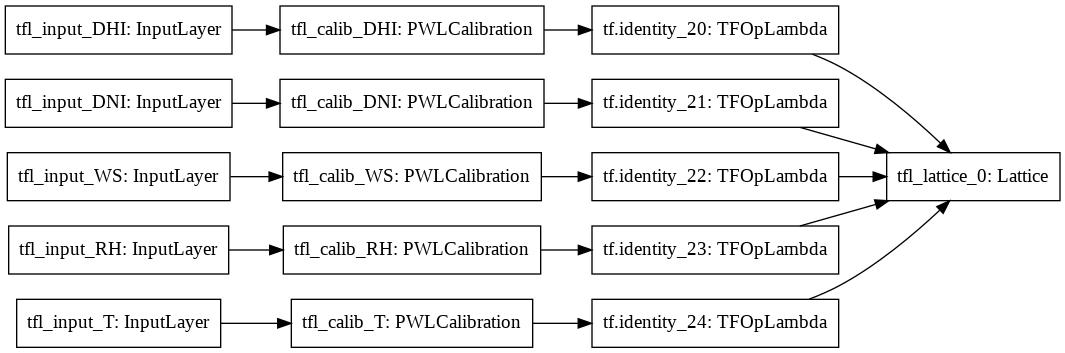

In [ ]:
tmp_lattice_model = create_lattice_model("tmp_lattice_model")
tf.keras.utils.plot_model(tmp_lattice_model, show_layer_names = True, show_shapes = False, rankdir = "LR")

In [ ]:
del tmp_lattice_model

In [ ]:
tmp = create_target_model("foo", "bar")
tmp.summary()

Model: "foo"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               [(None, 1), (None, 1 0           input_2[0][0]                    
__________________________________________________________________________________________________
bar (CalibratedLattice)         (None, 1)            97          lambda_1[0][0]                   
                                                                 lambda_1[0][1]                   
                                                                 lambda_1[0][2]                   
                                                                 lambda_1[0][3]                 

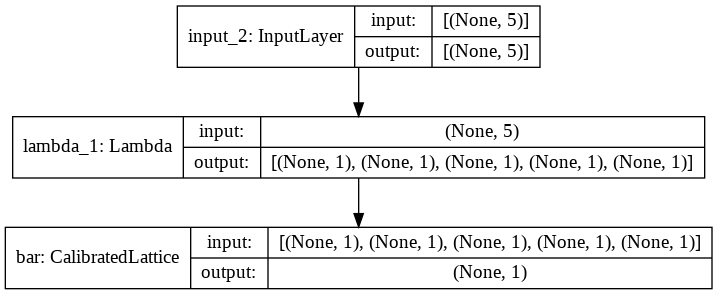

In [ ]:
tf.keras.utils.plot_model(tmp, show_layer_names = True, show_shapes = True, rankdir = "TB")

In [ ]:
del tmp

## **Autoregressive-LSTM Model**


```
"""Pytorch Style with Class"""
class AR_LSTM(tf.keras.Model):
    def __init__(self, target_model, units, out_steps, name):
        super(AR_LSTM, self).__init__(name = name)
        self.target_model = target_model # [batch, 7] => [batch, 1]
        self.units = units
        self.out_steps = out_steps
        self.num_features = args["NUM_FEATURES"]
        
        self.lstm_rnn = tf.keras.layers.RNN([
            tf.keras.layers.LSTMCell(self.units),
            tf.keras.layers.LSTMCell(self.units),
            tf.keras.layers.LSTMCell(self.units)], return_state = True)
        self.dense = tf.keras.layers.Dense(self.num_features)
        
    
    def warmup(self, inputs):
        # [batch, time, features] => [batch, units]
        x, *state = self.lstm_rnn(inputs)
        # [batch, units] => [batch, num_features]
        prediction = self.dense(x)
        return prediction, state
        
        
    def call(self, inputs, training = None):
        aux_outputs, real_outputs = [], []
        
        prediction, state = self.warmup(inputs)
        
        aux_outputs.append(prediction)
        real_outputs.append(self.target_model(prediction))
        
        for n in range(1, self.out_steps):
            x = tf.expand_dims(prediction, axis = 1)
            # [batch, num_features] => [batch, units]
            x, *state = self.lstm_rnn(x, initial_state = state, training = training)
            # [batch, units] => [batch, num_features]
            prediction = self.dense(x)
            
            aux_outputs.append(prediction)
            real_outputs.append(self.target_model(prediction))
            
        aux_outputs = tf.stack(aux_outputs, axis = 1)
        real_outputs = tf.stack(real_outputs, axis = 1)
        return (aux_outputs, real_outputs)
```

When implementing a model using a functional API, you can use the powerful visualization function provided by keras. You can check the number of parameters for each layer by using the model.summary() function, and you can visualize the entire flow diagram of the model by using tf.keras.utils.plot_model().

By using these tasks, you can see the I/O size of each layer at a glance, so it will reduce the hassle of checking the shape by calling the function inside the class as follows.

```
# Make a tmperary model.
tmp = AR_LSTM(...)

# Make dummy dataset.
dummy_x = tf.zeros([args["GLOBAL_BATCH_SIZE"], args["WINDOW_INP"], args["NUM_FEATURES"]], dtype = tf.float32)
print(f"dummy_x.shape: {dummy_x.shape}")

# Check the shapes of wampup and call functions.
dummy_w, _ = tmp.warmup(dummy_x)
dummy_y, dummy_z = tmp(dummy_x)

# Print the shapes.
print(f"The shapes of warmup output: {dummy_w.shape}")
print(f"The shapes of auxiliary output: {dummy_y.shape}")
print(f"The shapes of real output: {dummy_z.shape}")
```

As a result, these tasks will have a positive impact on the future direction of the project by reminding you of the need to increase or decrease the size of the model.

In [ ]:
def create_AR_LSTM(model_name, target_model, units, out_steps):
    # Defines some of the layers used repeatedly.
    lstm_rnn = tf.keras.layers.RNN([
        tf.keras.layers.LSTMCell(units),
        tf.keras.layers.LSTMCell(units),
        tf.keras.layers.LSTMCell(units)], return_state = True)
    dense = tf.keras.layers.Dense(args["NUM_FEATURES"])
    reshape = tf.keras.layers.Reshape((1, args["NUM_FEATURES"]), name = "expand_dims")
    aux_outputs, real_outputs = [], []

    # Entry flow.
    model_input = tf.keras.layers.Input([args["WINDOW_INP"], args["NUM_FEATURES"]], dtype = tf.float32)

    # Warm-up.
    x, *state = lstm_rnn(model_input)
    x = dense(x)

    aux_outputs.append(x)
    real_outputs.append(target_model(x))

    # Middle flow.
    for _ in range(1, out_steps):
        x = reshape(x) # same as "x = tf.expand_dims(x, axis = 1)"
        x, *state = lstm_rnn(x, initial_state = state)
        x = dense(x)

        aux_outputs.append(x)
        real_outputs.append(target_model(x))

    # Exit flow.
    aux_output = tf.keras.layers.Lambda(lambda x: tf.stack(x, axis = 1), name = "aux")(aux_outputs)
    real_output = tf.keras.layers.Lambda(lambda x: tf.stack(x, axis = 1), name = "real")(real_outputs)

    return tf.keras.Model(
        inputs = model_input,
        outputs = [aux_output, real_output],
        name = model_name)

In [ ]:
tmp = create_AR_LSTM(
    model_name = "tmp",
    target_model = create_target_model("foo", "bar"),
    units = 64, 
    out_steps = 4) # reduce from 96 to 4 to visualize

tmp.summary()

Model: "tmp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 336, 5)]     0                                            
__________________________________________________________________________________________________
rnn (RNN)                       [(None, 64), [(None, 83968       input_4[0][0]                    
                                                                 expand_dims[0][0]                
                                                                 rnn[0][1]                        
                                                                 rnn[0][2]                        
                                                                 rnn[0][3]                        
                                                                 rnn[0][4]                      

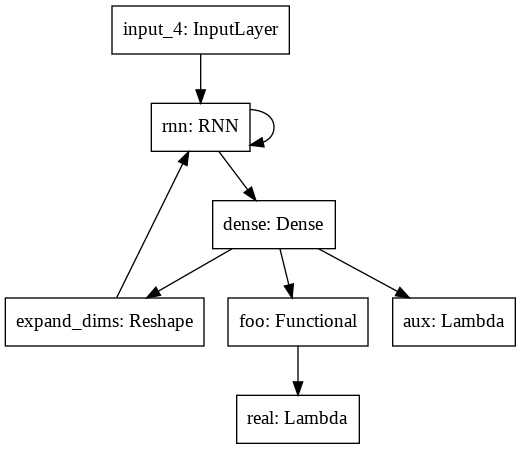

In [ ]:
# Abstract.
tf.keras.utils.plot_model(tmp, show_layer_names = True, show_shapes = False, rankdir = "TB")

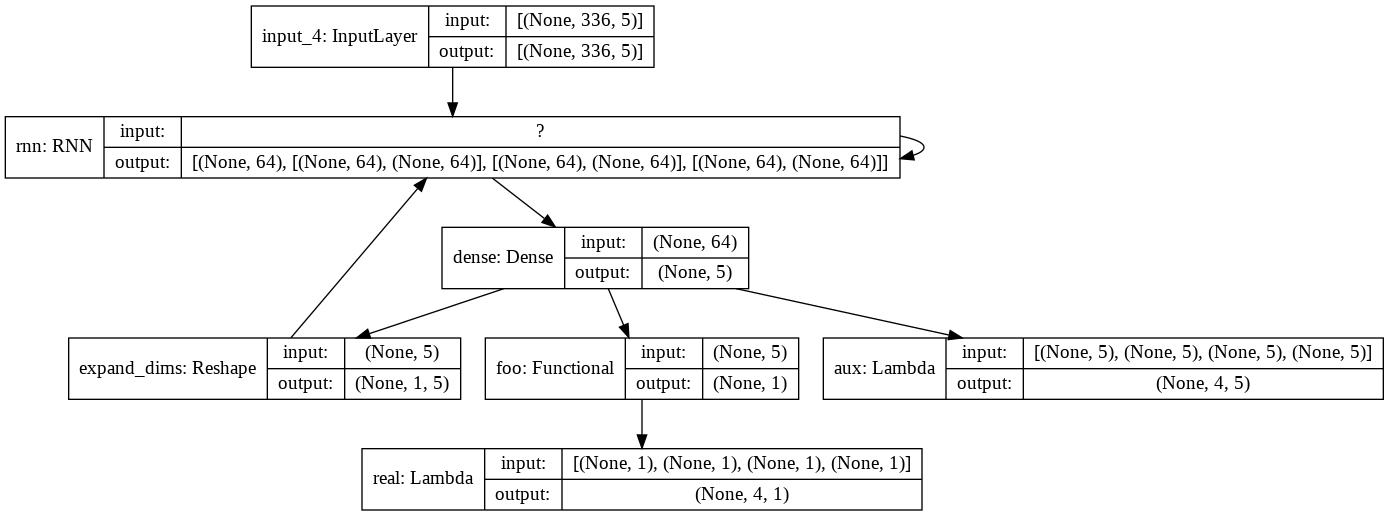

In [ ]:
# Same as above plot.
tf.keras.utils.plot_model(tmp, show_layer_names = True, show_shapes = True, rankdir = "TB")

In [ ]:
del tmp

# **Compile and Fit**

In [ ]:
def get_callbacks(model_name: str):
    """Get checkpoint and tensorboard callbacks."""
    # Checkpoint callback.
    ckpt_path = os.path.join(
        os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], 
        model_name, "cp-{epoch:03d}-{val_real_loss:.4f}.ckpt")
    ckpt_dir = os.path.dirname(ckpt_path)
    os.makedirs(ckpt_dir, exist_ok = True)
    
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        ckpt_path, verbose = 0, monitor = "val_real_loss", save_weights_only = True, save_best_only = True)
    
    # # TensorBoard callback.
    # log_dir = os.path.join(
    #     "logs", "fit", os.environ["NOTEBOOKNAME"], datetime.datetime.now().strftime(f"{model_name}-%Y%m%d-%H%M%S"))
    # tb_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)
    
    return [cp_callback]
    

def compile_and_fit(model, tau, tr_dataset, vl_dataset, epochs, verbose = 0, loss_weights = None):
    """Compile and fit the model."""
    model.compile(
        loss = CustomPinballLoss(tau = tau),
        loss_weights = loss_weights,
        optimizer = tf.keras.optimizers.Adam(args["INIT_LR"]))
    
    print(f"Model {model.name}...")

    history = model.fit(
        tr_dataset,
        validation_data = vl_dataset,
        epochs = epochs,
        verbose = verbose,
        callbacks = get_callbacks(model.name))

    return history

In [ ]:
%%time

for tau in np.arange(0.1, 1, 0.1):
    model = create_AR_LSTM(
        model_name = f"P{tau:.1f}",
        target_model = create_target_model(f"T{tau:.1f}", f"L{tau:.1f}"),
        units = args["NUM_UNITS"],
        out_steps = args["WINDOW_TAR"])

    _ = compile_and_fit(model, tau, tr_dataset, vl_dataset, args["EPOCH"], verbose = 2, loss_weights = [0.2, 1.0])

    del model

Model P0.1...
Epoch 1/50
7/7 - 319s - loss: 17.4725 - aux_loss: 7.5431 - real_loss: 15.9627 - val_loss: 17.2587 - val_aux_loss: 7.4143 - val_real_loss: 15.7751
Epoch 2/50
7/7 - 14s - loss: 16.7752 - aux_loss: 7.5469 - real_loss: 15.2652 - val_loss: 16.2115 - val_aux_loss: 7.5239 - val_real_loss: 14.7062
Epoch 3/50
7/7 - 14s - loss: 15.9200 - aux_loss: 7.5884 - real_loss: 14.4019 - val_loss: 15.5964 - val_aux_loss: 7.5289 - val_real_loss: 14.0902
Epoch 4/50
7/7 - 13s - loss: 15.3810 - aux_loss: 7.5654 - real_loss: 13.8676 - val_loss: 15.1814 - val_aux_loss: 7.5368 - val_real_loss: 13.6738
Epoch 5/50
7/7 - 13s - loss: 15.0236 - aux_loss: 7.5761 - real_loss: 13.5082 - val_loss: 14.8872 - val_aux_loss: 7.5604 - val_real_loss: 13.3750
Epoch 6/50
7/7 - 13s - loss: 14.7665 - aux_loss: 7.5959 - real_loss: 13.2471 - val_loss: 14.6734 - val_aux_loss: 7.5761 - val_real_loss: 13.1580
Epoch 7/50
7/7 - 13s - loss: 14.5761 - aux_loss: 7.6055 - real_loss: 13.0548 - val_loss: 14.5090 - val_aux_loss: 7.

## **Make Clean Checkpoints**

In [ ]:
# %%time

# ckpt_folders = sorted(glob.glob(os.path.join(os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], "P*")))
# max_to_keep = 3

# for f in ckpt_folders:
#     # 7 files must be located in ckpt_folders. (latest 3 ckpt and checkpoint file)
#     assert len(os.listdir(f)) >= (1 + max_to_keep * 2), f"Checkpoints in {f} is less then 3 (max_to_keep)."
    
#     rm_files = os.listdir(f)[1:-2*max_to_keep] # [1:-6]
#     _ = [os.remove(rm_file) for rm_file in rm_files]

# **Visualize**

## **Plot Histories**

In [ ]:
def draw_histories(histories):
    """Draw 9 histories in one plot."""
    assert len(histories.keys) == args["NUM_QUANTILE"]
    
    plt.figure(figsize = (14, 9), facecolor = "white", dpi = 96)

    for model_name, history in histories.items():
        pos = int(model_name.split(".")[-1])
        plt.subplot(3, 3, pos)
                
        plt.plot(history.epoch, history.history["output_2_loss"], label = "output_2_loss")
        plt.plot(history.epoch, history.history["val_output_2_loss"], label = "val_output_2_loss")
    
        plt.legend()
        plt.title(title, fontsize = "x-large")
        plt.xlabel("Epoch")
        plt.ylabel("Pinball Loss")
    
        plt.grid(True)
        
    plt.tight_layout()
    plt.show()

In [ ]:
draw_histories(histories)

## **Target Model Prediction**

In [75]:
def load_latest_models(ckpt_folders: list) -> list:
    """Load latest weights of target model from saved ckeckpoints."""    
    models = []
    for f in ckpt_folders:
        latest = tf.train.latest_checkpoint(f)
        print(f"Load latest checkpoints: {latest}...")
        
        tau = float(latest.split(os.path.sep)[-2][1:]) # ckpt/[notebookname]/P0.1/...

        # Define a new AR-LSTM model and load checkpoints.
        model = create_AR_LSTM(
            model_name = f"P{tau:.1f}",
            target_model = create_target_model(f"T{tau:.1f}", f"L{tau:.1f}"),
            units = args["NUM_UNITS"],
            out_steps = args["WINDOW_TAR"])

        ckpt = tf.train.Checkpoint(model)
        ckpt.restore(latest).expect_partial()

        models.append(model)
        
    return models


def draw_pred(inputs, y_preds, y_true, save_fig = True):
    """Draw the predictions and labels."""
    inputs, y_true = np.squeeze(inputs), np.squeeze(y_true)
    y_preds = [np.squeeze(y_pred) for y_pred in y_preds]
    
    plt.figure(figsize = (14, 4 * args["NUM_QUANTILE"]), facecolor = "white")
    
    for i, (y_pred, tau) in enumerate(zip(y_preds, np.arange(0.1, 1, 0.1))):
        plt.subplot(9, 1, i + 1)
        
        plt.plot(np.arange(len(inputs)), inputs, lw = 1.5, label = "Inputs")
        plt.plot(np.arange(len(inputs), len(inputs) + len(y_pred), 1), y_pred, marker = "o", lw = 1.5, label = "Predictions")
        plt.plot(np.arange(len(inputs), len(inputs) + len(y_true), 1), y_true, marker = "X", lw = 1.5, label = "Label")
    
        plt.title(f"Target Model T{tau:.1f}")
        plt.xlabel("Time [day]")
        plt.ylabel("Target")
        plt.ylim([-0.8, max(y_true) * 1.1])
        plt.legend()

        plt.xticks(np.arange(0, args["WINDOW_INP"] + args["WINDOW_TAR"] + 1, 24 * 2), [f"D+{i}" for i in np.arange(10)])
        plt.grid(True)
        
    plt.tight_layout()
    
    if save_fig:
        plt.savefig(f"pngs/{os.environ['NOTEBOOKNAME']}.png", dpi = 96)
        
    plt.show()

Load latest checkpoints: /content/drive/MyDrive/dacon/dacon-sunlight/ckpt/try42/P0.1/cp-050-8.4694.ckpt...
Load latest checkpoints: /content/drive/MyDrive/dacon/dacon-sunlight/ckpt/try42/P0.2/cp-050-8.2218.ckpt...
Load latest checkpoints: /content/drive/MyDrive/dacon/dacon-sunlight/ckpt/try42/P0.3/cp-050-8.8461.ckpt...
Load latest checkpoints: /content/drive/MyDrive/dacon/dacon-sunlight/ckpt/try42/P0.4/cp-050-9.3473.ckpt...
Load latest checkpoints: /content/drive/MyDrive/dacon/dacon-sunlight/ckpt/try42/P0.5/cp-048-7.4975.ckpt...
Load latest checkpoints: /content/drive/MyDrive/dacon/dacon-sunlight/ckpt/try42/P0.6/cp-050-6.5236.ckpt...
Load latest checkpoints: /content/drive/MyDrive/dacon/dacon-sunlight/ckpt/try42/P0.7/cp-050-5.8807.ckpt...
Load latest checkpoints: /content/drive/MyDrive/dacon/dacon-sunlight/ckpt/try42/P0.8/cp-049-5.2974.ckpt...
Load latest checkpoints: /content/drive/MyDrive/dacon/dacon-sunlight/ckpt/try42/P0.9/cp-049-5.4166.ckpt...


FileNotFoundError: ignored

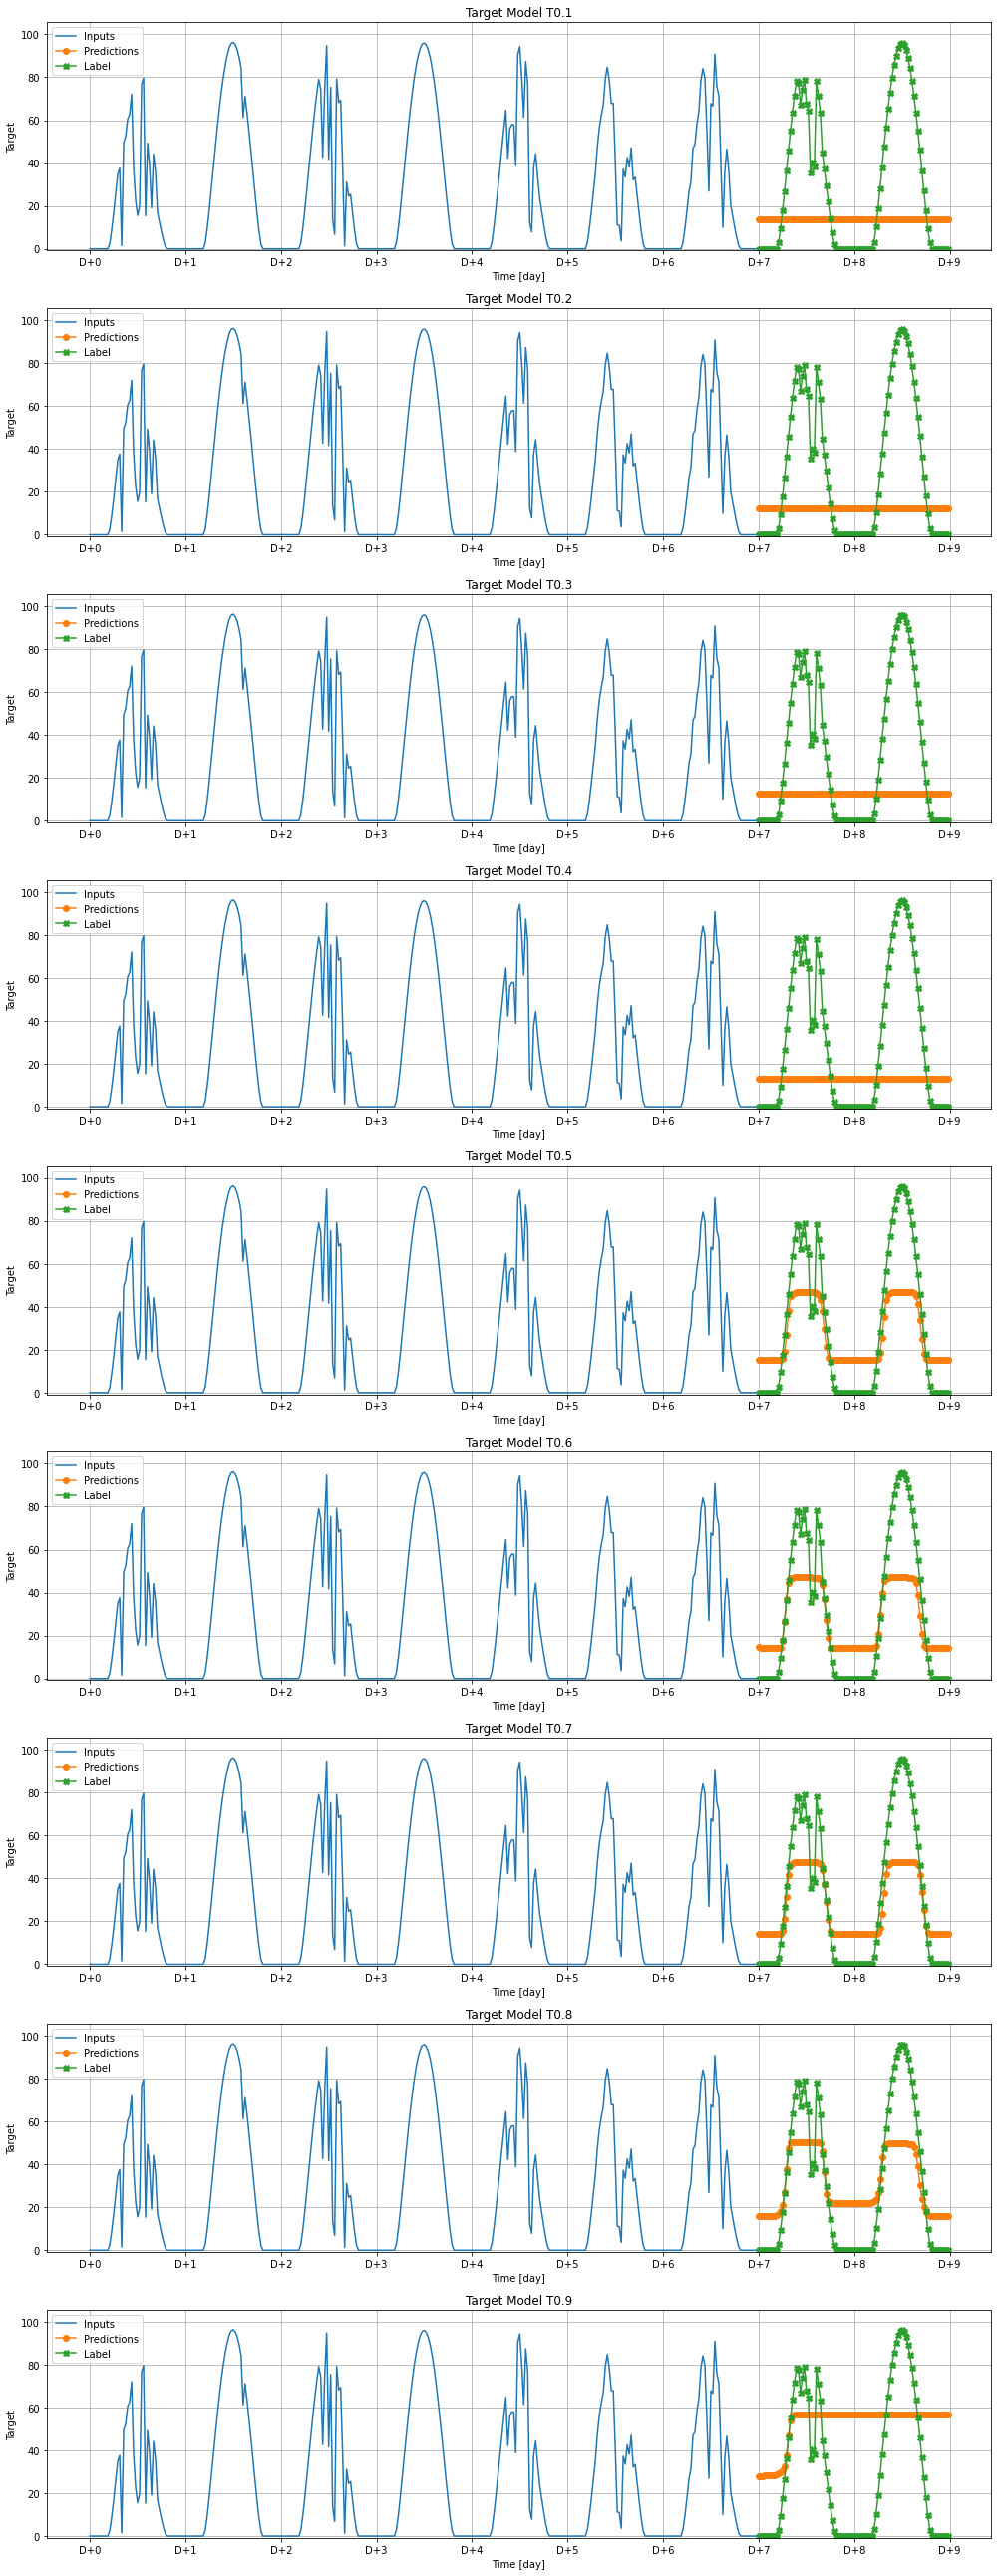

In [76]:
%%time

# Restore latest models from saved checkpoints.
ckpt_folders = sorted(glob.glob(os.path.join(os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], "P*")))
models = load_latest_models(ckpt_folders)

# Now, unbatch the dataset to predict only one sequences (i.e. 7 days).
unbatched_vl_dataset = vl_dataset.unbatch().batch(1)

for t in unbatched_vl_dataset.take(1):
    x, (_, r_y) = t # inp, aux_tar, real_tar
    
    draw_pred(
        inputs = vl_tensor[:args["WINDOW_INP"], -1], # not x
        y_preds = [model.predict(x)[-1] for model in models],
        y_true = r_y,
        save_fig = False)

## **Make Submissions**

In [ ]:
%%time
# Restore latest models from saved checkpoints.
ckpt_folders = sorted(glob.glob(os.path.join(os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], "P*")))
models = load_latest_models(ckpt_folders)

# Predict the test datasets.
# We need to drop auxiliary outputs and squeeze dimensions (i.e. [batch, 96, 1] => [batch, 96]).
preds = [np.array(model.predict(ts_dataset)[-1])[..., 0] for model in models]

Load latest checkpoints: ckpt/try40/P0.1/cp-050-0.0704.ckpt...
Load latest checkpoints: ckpt/try40/P0.2/cp-048-0.1197.ckpt...
Load latest checkpoints: ckpt/try40/P0.3/cp-050-0.1513.ckpt...
Load latest checkpoints: ckpt/try40/P0.4/cp-050-0.1726.ckpt...
Load latest checkpoints: ckpt/try40/P0.5/cp-048-0.1837.ckpt...
Load latest checkpoints: ckpt/try40/P0.6/cp-036-0.1790.ckpt...
Load latest checkpoints: ckpt/try40/P0.7/cp-042-0.1655.ckpt...
Load latest checkpoints: ckpt/try40/P0.8/cp-042-0.1339.ckpt...
Load latest checkpoints: ckpt/try40/P0.9/cp-050-0.0837.ckpt...
CPU times: user 3min 15s, sys: 232 ms, total: 3min 15s
Wall time: 3min 15s


In [ ]:
submission = pd.read_csv(os.path.join(os.environ["LOCAL_DATA_PATH"], "sample_submission.csv"), index_col = "id")
submission.head()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
id,,,,,,,,,
0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
for column, pred in zip(submission.columns, preds):
    foo = np.reshape(pred, (-1,))
    foo = (foo * args["TARGET_STD"]) + args["TARGET_MEAN"]
    foo = np.where(foo < 0, 0, foo) # clip by value
    
    submission[column] = foo

In [ ]:
submission.head()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
id,,,,,,,,,
0.csv_Day7_0h00m,0.0,0.000000,0.0,0.321136,0.059587,0.0,0.000000,0.0,0.0
0.csv_Day7_0h30m,0.0,0.000000,0.0,0.346798,0.099693,0.0,0.000000,0.0,0.0
0.csv_Day7_1h00m,0.0,0.010199,0.0,0.343756,0.106472,0.0,0.059597,0.0,0.0
0.csv_Day7_1h30m,0.0,0.000000,0.0,0.361908,0.105865,0.0,0.050045,0.0,0.0
0.csv_Day7_2h00m,0.0,0.000000,0.0,0.316153,0.242077,0.0,0.025000,0.0,0.0


In [ ]:
submission.to_csv(os.path.join(os.environ["SUBMISSION_PATH"], f"{os.environ['NOTEBOOKNAME']}_submission.csv"))

In [ ]:
%%time
for tau in np.arange(0.1, 1, 0.1):
    model = TARGET_MODEL(f"T{tau:.1f}")
    _ = compile_and_fit(model, tau, tr_dataset, vl_dataset, args["TARGET_EPOCH"])

Model T0.1...
Model T0.2...
Model T0.3...
Model T0.4...
Model T0.5...
Model T0.6...
Model T0.7...
Model T0.8...
Model T0.9...
CPU times: user 1h 6min 18s, sys: 3min 53s, total: 1h 10min 11s
Wall time: 45min 7s


## **Predict**

In [ ]:
def load_latest_specific_models(ckpt_folders: list, create_model_fn) -> list:
    """Return latest models for a specific function s.t. makes a model."""
    models = []
    print()
    for f in ckpt_folders:
        latest = tf.train.latest_checkpoint(f)
        print(f"Load latest checkpoints: {latest}...")

        # Define a new target model and load checkpoints.
        model = create_model_fn(model_name = latest.split(os.path.sep)[2])
        ckpt = tf.train.Checkpoint(model)
        ckpt.restore(latest).expect_partial()

        models.append(model)
        
    return models

In [ ]:
target_models = load_latest_specific_models(
    ckpt_folders = sorted(glob.glob(os.path.join(os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], "T*"))),
    create_model_fn = TARGET_MODEL)

# Sample evaluation.
target_models[0].compile(
    loss = tfa.losses.PinballLoss(tau = 0.1),
    optimizer = tf.keras.optimizers.Adam(args["INIT_LR"]))
target_models[0].evaluate(ts_dataset, verbose = 1)


Load latest checkpoints: ckpt/try40/T0.1/cp-372-0.0048.ckpt...
Load latest checkpoints: ckpt/try40/T0.2/cp-466-0.0073.ckpt...
Load latest checkpoints: ckpt/try40/T0.3/cp-496-0.0089.ckpt...
Load latest checkpoints: ckpt/try40/T0.4/cp-421-0.0094.ckpt...
Load latest checkpoints: ckpt/try40/T0.5/cp-492-0.0100.ckpt...
Load latest checkpoints: ckpt/try40/T0.6/cp-432-0.0100.ckpt...
Load latest checkpoints: ckpt/try40/T0.7/cp-500-0.0084.ckpt...
Load latest checkpoints: ckpt/try40/T0.8/cp-499-0.0067.ckpt...
Load latest checkpoints: ckpt/try40/T0.9/cp-388-0.0050.ckpt...
213/213 [==============================] - 0s 1ms/step - loss: 0.0061


0.0062280986458063126

## **Visualize**

Visualize between label and predictions.

In [ ]:
def draw_history(history, title):
    
    plt.figure(figsize = (14, 4), facecolor = "white", dpi = 80)
    
    plt.plot(history.epoch, history.history["loss"], label = "loss")
    plt.plot(history.epoch, history.history["val_loss"], label = "val_loss")
    
    plt.legend()
    plt.title(title, fontsize = "x-large")
    plt.xlabel("Epoch")
    plt.ylabel("Pinball Loss")
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# for tau, history in zip(np.arange(0.1, 1, 0.1), histories):
#     draw_history(history, title = f"Target Model T{tau:.1f}")

In [ ]:
# %tensorboard --logdir logs/fit --host jupyter-server --port=6006

In [ ]:
def draw_pred(y_pred, y_true, model_name, save_fig = True):
    """Draw the predictions and labels."""
    plt.figure(figsize = (14, 4), facecolor = "white")
    plt.plot(y_pred, lw = 1.5, label = "Predictions")
    plt.plot(y_true, lw = 1.5, label = "Label")
    
    plt.title(f"Target Model {model_name}")
    plt.xlabel("Time [day]")
    plt.ylabel("Target [kW]")
    plt.ylim([-0.8, max(y_true) * 1.1])
    plt.legend()
    
    plt.xticks(np.arange(0, args["WINDOW_INP"] + 1, 24 * 2), [f"D+{i}" for i in np.arange(8)])
    plt.grid(True)
    plt.tight_layout()
    
    if save_fig:
        plt.savefig(f"./pngs/{os.environ['NOTEBOOKNAME']}_target-model-{model_name}.png", dpi = 300)
        
    plt.show()


Load latest checkpoints: ckpt/try40/T0.1/cp-372-0.0048.ckpt...
Load latest checkpoints: ckpt/try40/T0.2/cp-466-0.0073.ckpt...
Load latest checkpoints: ckpt/try40/T0.3/cp-496-0.0089.ckpt...
Load latest checkpoints: ckpt/try40/T0.4/cp-421-0.0094.ckpt...
Load latest checkpoints: ckpt/try40/T0.5/cp-492-0.0100.ckpt...
Load latest checkpoints: ckpt/try40/T0.6/cp-432-0.0100.ckpt...
Load latest checkpoints: ckpt/try40/T0.7/cp-500-0.0084.ckpt...
Load latest checkpoints: ckpt/try40/T0.8/cp-499-0.0067.ckpt...
Load latest checkpoints: ckpt/try40/T0.9/cp-388-0.0050.ckpt...


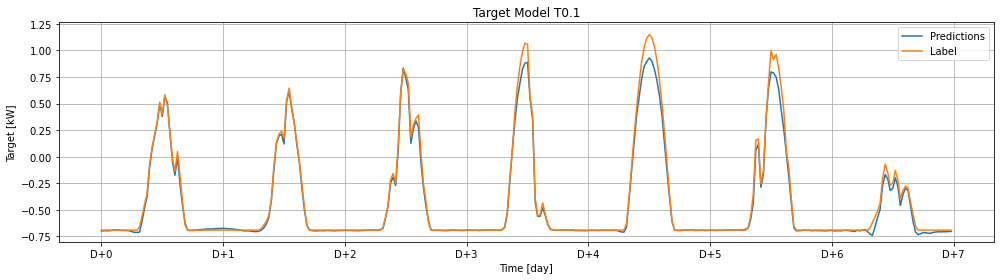

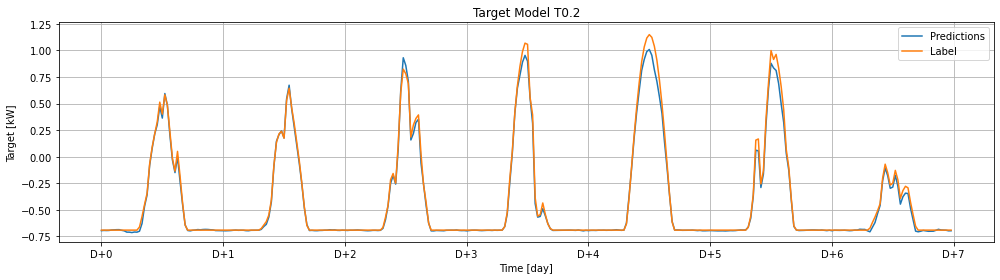

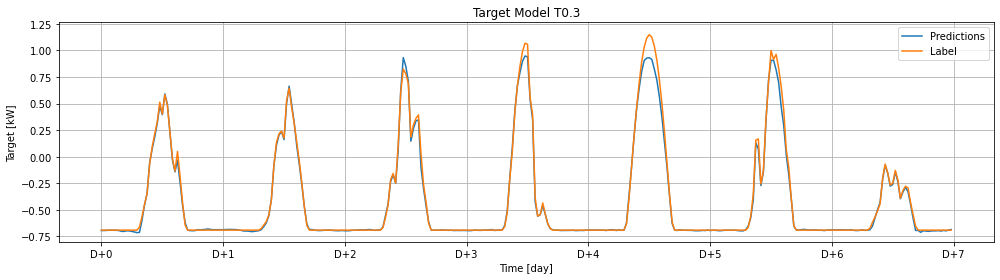

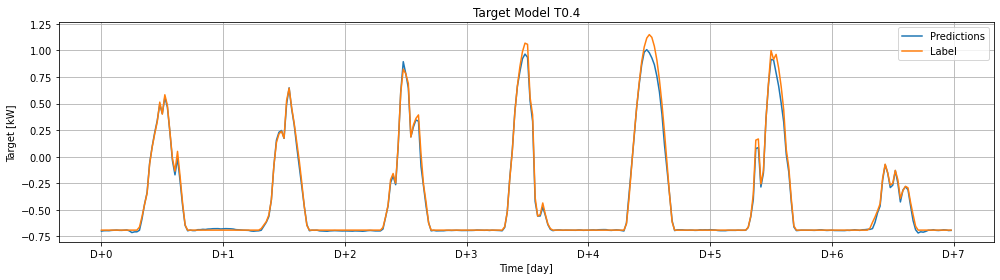

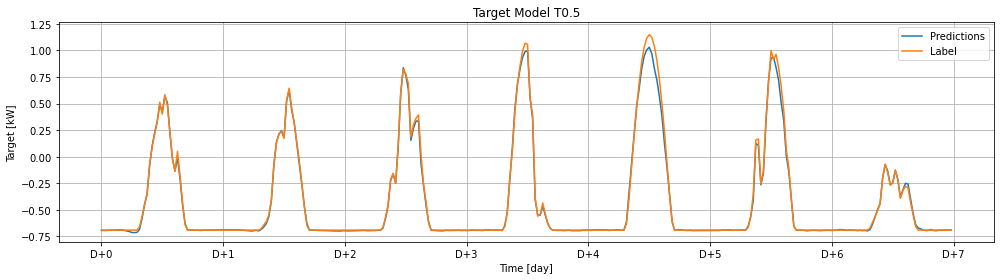

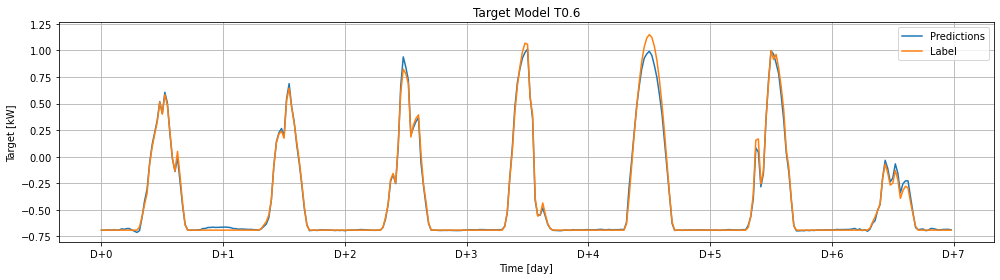

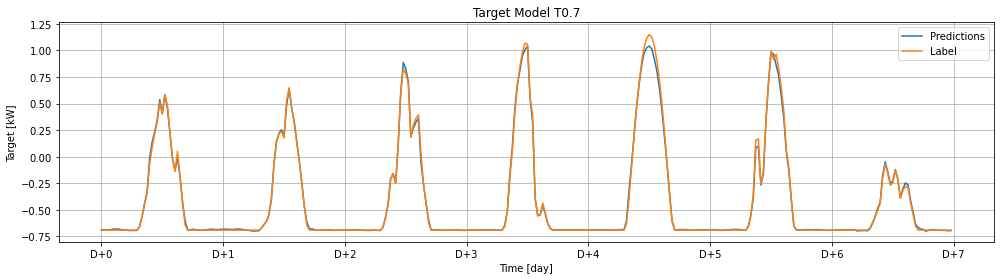

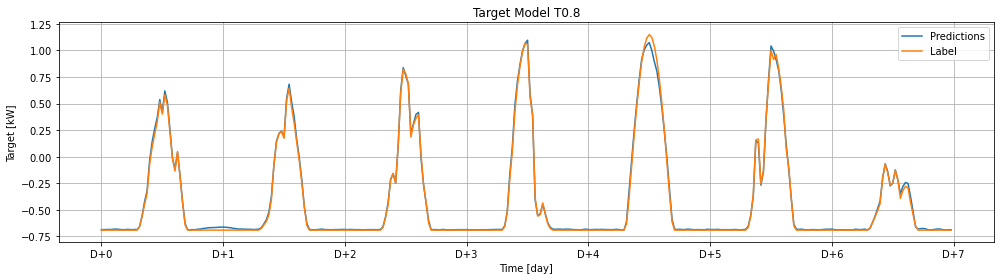

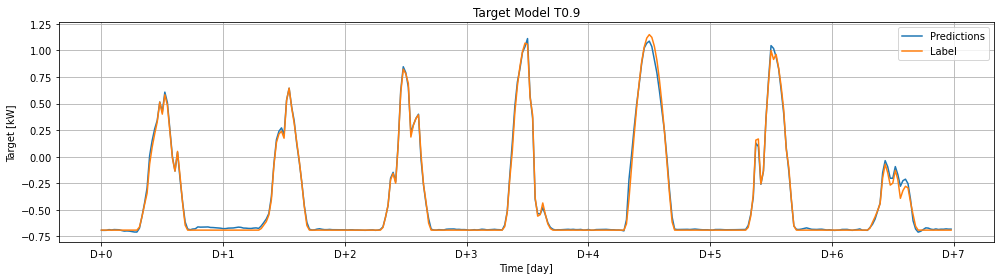

In [ ]:
ts_dataset = ts_dataset.unbatch().batch(args["WINDOW_INP"])
target_models = load_latest_specific_models(
    ckpt_folders = sorted(glob.glob(os.path.join(os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], "T*"))),
    create_model_fn = TARGET_MODEL)

for t in ts_dataset.take(1):
    x, y = t # inp, tar
    
    for target_model in target_models:
        draw_pred(y_pred = target_model.predict(x), y_true = y, model_name = target_model.name)

# **Phase \#2: Autoregressive Model**

## **Create Network**

In [ ]:
class AR_LSTM(tf.keras.Model):
    def __init__(self, target_model, units, out_steps, name):
        super(AR_LSTM, self).__init__(name = name)
        self.target_model = target_model # [batch, 7] => [batch, 1]
        self.units = units
        self.out_steps = out_steps
        self.num_features = args["NUM_FEATURES"]
        
        self.lstm_rnn = tf.keras.layers.RNN([
            tf.keras.layers.LSTMCell(self.units),
            tf.keras.layers.LSTMCell(self.units),
            tf.keras.layers.LSTMCell(self.units)], return_state = True)
        self.dense = tf.keras.layers.Dense(self.num_features)
        
    
    def warmup(self, inputs):
        # [batch, time, features] => [batch, units]
        x, *state = self.lstm_rnn(inputs)
        # [batch, units] => [batch, num_features]
        prediction = self.dense(x)
        return prediction, state
        
        
    def call(self, inputs, training = None):
        aux_outputs, real_outputs = [], []
        
        prediction, state = self.warmup(inputs)
        
        aux_outputs.append(prediction)
        real_outputs.append(self.target_model(prediction))
        
        for n in range(1, self.out_steps):
            x = tf.expand_dims(prediction, axis = 1)
            # [batch, num_features] => [batch, units]
            x, *state = self.lstm_rnn(x, initial_state = state, training = training)
            # [batch, units] => [batch, num_features]
            prediction = self.dense(x)
            
            aux_outputs.append(prediction)
            real_outputs.append(self.target_model(prediction))
            
        aux_outputs = tf.stack(aux_outputs, axis = 1)
        real_outputs = tf.stack(real_outputs, axis = 1)
        return (aux_outputs, real_outputs)

## **Compile and Fit**

In [ ]:
%%time

target_models = load_latest_specific_models(
    ckpt_folders = sorted(glob.glob(os.path.join(os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], "T*"))),
    create_model_fn = TARGET_MODEL)
target_models.reverse() # to use pop()

for tau in np.arange(0.1, 1, 0.1):
    model = AR_LSTM(
        target_model = target_models.pop(),
        units = args["NUM_UNITS"],
        out_steps = args["WINDOW_TAR"],
        name = f"P{tau:.1f}")

    _ = compile_and_fit(model, tau, tr_dataset, vl_dataset, args["EPOCH"], verbose = 2, loss_weights = [1.0, 0.2])


Load latest checkpoints: ckpt/try40/T0.1/cp-372-0.0048.ckpt...
Load latest checkpoints: ckpt/try40/T0.2/cp-466-0.0073.ckpt...
Load latest checkpoints: ckpt/try40/T0.3/cp-496-0.0089.ckpt...
Load latest checkpoints: ckpt/try40/T0.4/cp-421-0.0094.ckpt...
Load latest checkpoints: ckpt/try40/T0.5/cp-492-0.0100.ckpt...
Load latest checkpoints: ckpt/try40/T0.6/cp-432-0.0100.ckpt...
Load latest checkpoints: ckpt/try40/T0.7/cp-500-0.0084.ckpt...
Load latest checkpoints: ckpt/try40/T0.8/cp-499-0.0067.ckpt...
Load latest checkpoints: ckpt/try40/T0.9/cp-388-0.0050.ckpt...
Model P0.1...
Epoch 1/50
7/7 - 176s - loss: 0.3960 - output_1_loss: 0.3698 - output_2_loss: 0.1312 - val_loss: 0.2758 - val_output_1_loss: 0.2555 - val_output_2_loss: 0.1015
Epoch 2/50
7/7 - 6s - loss: 0.2094 - output_1_loss: 0.1865 - output_2_loss: 0.1144 - val_loss: 0.1600 - val_output_1_loss: 0.1385 - val_output_2_loss: 0.1077
Epoch 3/50
7/7 - 6s - loss: 0.1529 - output_1_loss: 0.1346 - output_2_loss: 0.0913 - val_loss: 0.143

In [ ]:
# models[0].summary()

In [ ]:
# %tensorboard --logdir logs/fit --host jupyter-server

## **Predict**

In [ ]:
def load_latest_models():
    """Load latest weights of target model from saved ckeckpoints."""
    ckpt_folders = sorted(glob.glob(os.path.join(os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], "P*")))
    models = []

    for f in ckpt_folders:
        latest = tf.train.latest_checkpoint(f)
        print(f"Load latest checkpoints: {latest}...")

        # Define a new target model and load checkpoints.
        model_name = latest.split(os.path.sep)[2]
        model = AR_LSTM(
            target_model = TARGET_MODEL(model_name = f"T{model_name[1:]}"),
            units = args["NUM_UNITS"],
            out_steps = args["WINDOW_TAR"],
            name = model_name)

        ckpt = tf.train.Checkpoint(model)
        ckpt.restore(latest).expect_partial()

        models.append(model)
        
    return models

In [ ]:
%%time
models = load_latest_models()
preds = [np.array(model.predict(ts_dataset)[-1])[..., 0] for model in models] # use only real outputs.

Load latest checkpoints: ckpt/try40/P0.1/cp-050-0.0704.ckpt...
Load latest checkpoints: ckpt/try40/P0.2/cp-048-0.1197.ckpt...
Load latest checkpoints: ckpt/try40/P0.3/cp-050-0.1513.ckpt...
Load latest checkpoints: ckpt/try40/P0.4/cp-050-0.1726.ckpt...
Load latest checkpoints: ckpt/try40/P0.5/cp-048-0.1837.ckpt...
Load latest checkpoints: ckpt/try40/P0.6/cp-036-0.1790.ckpt...
Load latest checkpoints: ckpt/try40/P0.7/cp-042-0.1655.ckpt...
Load latest checkpoints: ckpt/try40/P0.8/cp-042-0.1339.ckpt...
Load latest checkpoints: ckpt/try40/P0.9/cp-050-0.0837.ckpt...
CPU times: user 3min 15s, sys: 232 ms, total: 3min 15s
Wall time: 3min 15s


In [ ]:
submission = pd.read_csv(os.path.join(os.environ["LOCAL_DATA_PATH"], "sample_submission.csv"), index_col = "id")
submission.head()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
id,,,,,,,,,
0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
for column, pred in zip(submission.columns, preds):
    foo = np.reshape(pred, (-1,))
    foo = (foo * args["TARGET_STD"]) + args["TARGET_MEAN"]
    foo = np.where(foo < 0, 0, foo) # clip by value
    
    submission[column] = foo

In [ ]:
submission.head()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
id,,,,,,,,,
0.csv_Day7_0h00m,0.0,0.000000,0.0,0.321136,0.059587,0.0,0.000000,0.0,0.0
0.csv_Day7_0h30m,0.0,0.000000,0.0,0.346798,0.099693,0.0,0.000000,0.0,0.0
0.csv_Day7_1h00m,0.0,0.010199,0.0,0.343756,0.106472,0.0,0.059597,0.0,0.0
0.csv_Day7_1h30m,0.0,0.000000,0.0,0.361908,0.105865,0.0,0.050045,0.0,0.0
0.csv_Day7_2h00m,0.0,0.000000,0.0,0.316153,0.242077,0.0,0.025000,0.0,0.0


In [ ]:
submission.to_csv(
    os.path.join(os.environ["SUBMISSION_PATH"], f"{os.environ['NOTEBOOKNAME']}_submission.csv"))